**IMPORTING THE DATA**

**Reading the csv files**

In [1]:
# Import the required libraries 
import numpy as np
import pandas as pd
import json

In [2]:
#For transaction records import the transactions dataset
transactions_data = pd.read_csv('transactions_data.csv')


In [4]:
#checking the number of rows and columns
rows, columns = transactions_data.shape
print(f'Number of rows in the dataset: {rows}')
print(f'Number of columns in the dataset: {columns}')

Number of rows in the dataset: 13305915
Number of columns in the dataset: 12


In [5]:
#Information about the dataset
transactions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   client_id       int64  
 3   card_id         int64  
 4   amount          object 
 5   use_chip        object 
 6   merchant_id     int64  
 7   merchant_city   object 
 8   merchant_state  object 
 9   zip             float64
 10  mcc             int64  
 11  errors          object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.2+ GB


In [6]:
#Shape of the dataset
print("Shape:", transactions_data.shape)
print(transactions_data.head())

Shape: (13305915, 12)
        id                 date  client_id  card_id   amount  \
0  7475327  2010-01-01 00:01:00       1556     2972  $-77.00   
1  7475328  2010-01-01 00:02:00        561     4575   $14.57   
2  7475329  2010-01-01 00:02:00       1129      102   $80.00   
3  7475331  2010-01-01 00:05:00        430     2860  $200.00   
4  7475332  2010-01-01 00:06:00        848     3915   $46.41   

            use_chip  merchant_id merchant_city merchant_state      zip   mcc  \
0  Swipe Transaction        59935        Beulah             ND  58523.0  5499   
1  Swipe Transaction        67570    Bettendorf             IA  52722.0  5311   
2  Swipe Transaction        27092         Vista             CA  92084.0  4829   
3  Swipe Transaction        27092   Crown Point             IN  46307.0  4829   
4  Swipe Transaction        13051       Harwood             MD  20776.0  5813   

  errors  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN  


In [10]:
#Finding the missing values of the dataset
print("Missing values found before imputations:", transactions_data.isnull().sum())


Missing values found before imputations: id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state     1563700
zip                1652706
mcc                      0
errors            13094522
dtype: int64


**UNSUPERVISED LEARNING USING ISOLATIONFOREST FOR ANOMOLY DETECTION**

**Load and preprocessing the transactions data**

In [11]:
# Converting raw date column to datetime objects
transactions_data['date'] = pd.to_datetime(transactions_data['date'])

# group the transaction amounts based on date
time_series = transactions_data.groupby('date')['amount'].sum().reset_index()

# Checking the first few rows ofthe data based on time-series
time_series.head()

,date,amount
0,2010-01-01 00:01:00,$-77.00
1,2010-01-01 00:02:00,$14.57$80.00
2,2010-01-01 00:05:00,$200.00
3,2010-01-01 00:06:00,$46.41
4,2010-01-01 00:07:00,$4.81


The raw date and time are converted to a dataframe with amount

**Feature engineering**

In [12]:
#Finding unique values in amount
print(time_series['amount'].unique())


['$-77.00' '$14.57$80.00' '$200.00' ... '$12.93$67.01' '$11.43$57.22'
 '$165.09$1.11$12.80']


In [13]:
# Removing the special characters
transactions_data['amount'] = transactions_data['amount'].replace(r'[^\d.]', '', regex=True)

# Converting the data to numeric format
transactions_data['amount'] = pd.to_numeric(transactions_data['amount'], errors='coerce')


In [14]:
# Re-aggregate after ensuring numeric conversion
time_series = transactions_data.groupby('date')['amount'].sum().reset_index()

# find the amount_difference based on time series
time_series['amount_difference'] = time_series['amount'].diff()


time_series = time_series.dropna()


print(time_series.head())


                 date  amount  amount_difference
1 2010-01-01 00:02:00   94.57              17.57
2 2010-01-01 00:05:00  200.00             105.43
3 2010-01-01 00:06:00   46.41            -153.59
4 2010-01-01 00:07:00    4.81             -41.60
5 2010-01-01 00:09:00   77.00              72.19


Feature engineering with 'amount column' - converted string to numeric, non-numeric characters, unique values. It is likely calculating the difference in amounts (amount_diff) between consecutive timestamps grouped by minutes. 

**Isolation model for anomaly detection**

In [15]:
#Imporint sklearn library for training
from sklearn.ensemble import IsolationForest

# Training the model
model = IsolationForest(contamination=0.05, random_state=42)
time_series['anomaly'] = model.fit_predict(time_series[['amount', 'amount_difference']])

#Map the values for interpretation
time_series['anomaly'] = time_series['anomaly'].map({0: 'normal', 1: 'anomaly'})

time_series.head()


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,date,amount,amount_difference,anomaly
1,2010-01-01 00:02:00,94.57,17.57,anomaly
2,2010-01-01 00:05:00,200.00,105.43,anomaly
3,2010-01-01 00:06:00,46.41,-153.59,anomaly
4,2010-01-01 00:07:00,4.81,-41.60,anomaly
5,2010-01-01 00:09:00,77.00,72.19,anomaly


Implemented unsupervised machine learning model i.e., isolation forest to check for anomaly detection.
Sudden positive and negative changes recognized as anomolies. 

**Visualization**

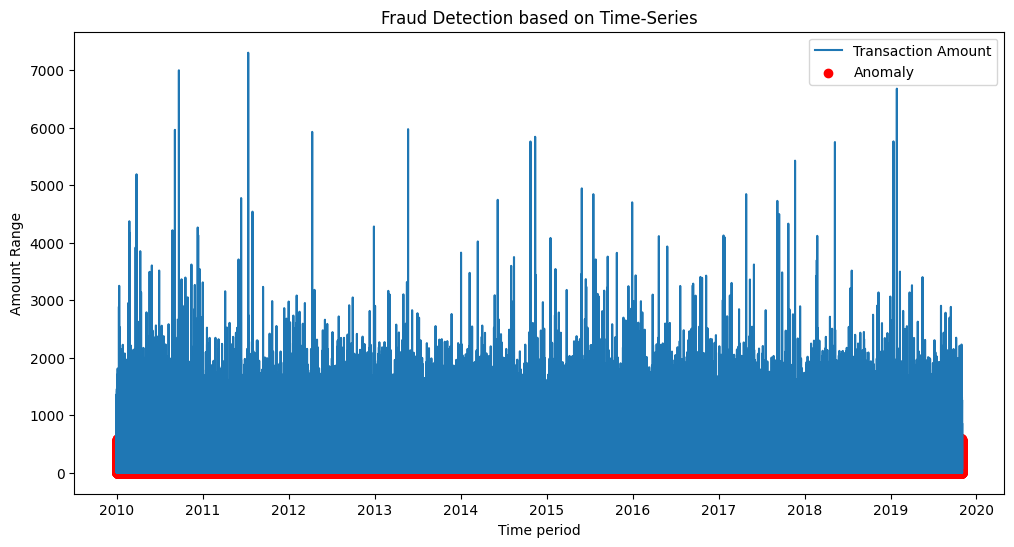

In [16]:
import matplotlib.pyplot as plt

# Plot transaction amounts with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(time_series['date'], time_series['amount'], label='Transaction Amount')
plt.scatter(
    time_series.loc[time_series['anomaly'] == 'anomaly', 'date'],
    time_series.loc[time_series['anomaly'] == 'anomaly', 'amount'],
    color='red', label='Anomaly'
)
plt.xlabel('Time period')
plt.ylabel('Amount Range')
plt.title('Fraud Detection based on Time-Series')
plt.legend()
plt.show()


Manual representation of graph for anomaly detection. 

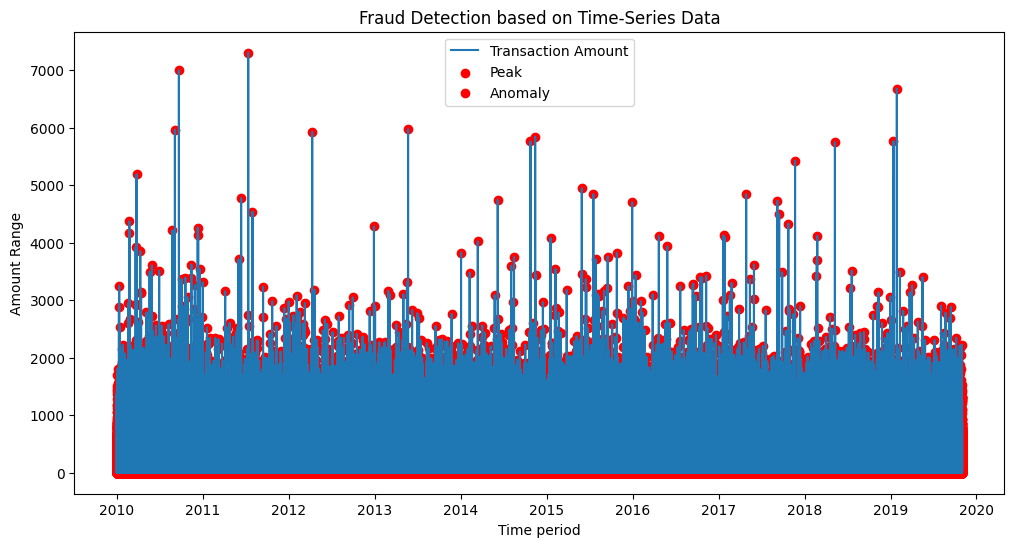

In [17]:
# Find the peaks of the transaction amount 
import scipy.signal

peaks, _ = scipy.signal.find_peaks(time_series['amount'])

# Plot the graph for outlier detection 
plt.figure(figsize=(12, 6))
plt.plot(time_series['date'], time_series['amount'], label='Transaction Amount')
plt.scatter(time_series['date'].iloc[peaks], time_series['amount'].iloc[peaks], color='red', label='Peak')
plt.scatter(
    time_series.loc[time_series['anomaly'] == 'anomaly', 'date'],
    time_series.loc[time_series['anomaly'] == 'anomaly', 'amount'],
    color='red', label='Anomaly'
)
plt.xlabel('Time period')
plt.ylabel('Amount Range')
plt.title('Fraud Detection/outliers based on Time-Series Data')
plt.legend()
plt.show()
